# Quantitative Risk Management - Topic 1 : Varlue at Risk (VaR)

**Authors : Hugo Michel**

### Import libs

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import norm

#Set personal directory
#os.chdir('/Users/ondineji/Library/Mobile Documents/com~apple~CloudDocs/Documents/ACADEMIQUE/M2 FTD/S2/Risk Management ')
os.chdir('C:/Users/humic/OneDrive/Documents/Ecole/SorbonneFTD/Cours/Quantitative_Risk_Management/Lecture 1 - VaR')

### Data Description



### Import data

In [2]:
def load_data(csv_file):
    # Load the data 
    data = pd.read_csv(csv_file)
    data['Date'] = pd.to_datetime(data['Date'])
    return data

csv_file = "10_asian_tech_stocks_closing_prices_10years.csv"
data = load_data(csv_file)
data

,Date,005930.KS,0700.HK,2330.TW,9988.HK,6758.T,INFY.BO,9984.T,9618.HK,9888.HK,...,066570.KS,2357.TW,036570.KS,RELIANCE.BO,TECHM.BO,7751.T,6752.T,6702.T,2354.TW,000063.SZ
0,2014-02-05,24740.0,102.099998,100.5,NaN,1600.0,447.693756,3518.0,NaN,NaN,...,62600.0,279.5,197000.0,408.075012,459.562500,2918.0,1262.0,5630.0,61.805332,NaN
1,2014-02-06,25180.0,101.699997,102.0,NaN,1624.0,445.431244,3650.0,NaN,NaN,...,62800.0,277.0,200000.0,407.924988,461.100006,2889.0,1210.0,5880.0,62.085415,NaN
2,2014-02-07,25500.0,104.900002,104.0,NaN,1691.0,445.837494,3687.5,NaN,NaN,...,61200.0,280.0,200000.0,407.149994,455.350006,2981.0,1192.0,5980.0,62.832310,11.391666
3,2014-02-10,25540.0,106.699997,103.0,NaN,1702.0,446.062500,3898.5,NaN,NaN,...,61600.0,285.5,204000.0,410.799988,457.637512,3010.0,1206.0,6060.0,62.925671,11.691666
4,2014-02-11,26220.0,106.000000,104.5,NaN,NaN,449.475006,NaN,NaN,NaN,...,60800.0,284.0,204000.0,402.750000,465.587494,NaN,NaN,NaN,62.925671,11.558333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,2024-01-29,74400.0,282.000000,648.0,72.599998,14355.0,1655.900024,6545.0,93.349998,105.099998,...,94300.0,444.0,195000.0,2896.149902,1314.599976,3796.0,1417.0,20745.0,50.700001,23.629999
2454,2024-01-30,74300.0,273.799988,642.0,71.150002,14480.0,1650.800049,6515.0,89.550003,103.400002,...,94500.0,447.5,198900.0,2814.850098,1317.699951,3783.0,1409.5,20785.0,50.400002,22.850000
2455,2024-01-31,72700.0,270.600006,628.0,69.550003,14695.0,1662.099976,6460.0,86.800003,101.400002,...,93500.0,445.5,198100.0,2853.199951,1333.449951,4080.0,1408.5,20840.0,50.500000,21.959999
2456,2024-02-01,73600.0,271.600006,628.0,71.050003,14390.0,1656.449951,6399.0,87.500000,102.800003,...,95100.0,447.0,199400.0,2852.699951,1311.949951,4034.0,1382.0,21080.0,50.799999,22.270000


### Build portfolio

To build our portfolio, we first cleaned our dataset. To do so, we use the following strategy:
1. Filter out our data according to a start date and end date

2. Fill `NaN` values: Since we have `NaN` due to the fact that each week-end, the stock exchange is closed, we chose to interpolate missing by taking the last value before a `NaN` value.

3. Select assets: we import 10 asian stocks and select two assets:

* Samsung Electronics Co Ltd (KRX: 005930)
* Tencent (0700.HK)

4. Convert the index in `datetime` object

5. Rename the columns of our portfolio according to the name of selected assets

In [3]:
def cleaned_data(data, start_date, end_date):
    # We filter the data to keep the close prices between  01-01-2015 and le 31-12-2015
    df_cleaned = data[data['Date'].between(start_date, end_date)]
    df_cleaned.set_index('Date', inplace=True)
    
    # We select the stocks of Samsung and Tencent and plot them
    df_cleaned = df_cleaned.iloc[:, :2] # Select Samsung and Tencent stocks selection 

    #Interpolate missing values (e.g., weekends and holidays) with the previous value
    df_cleaned = df_cleaned.fillna(method='ffill') 
    
    # Make sure that the index of df is of datetime type 
    df_cleaned.index = pd.to_datetime(df_cleaned.index)
    
    #Rename the columns
    df_cleaned.rename(columns={'005930.KS': 'Samsung', '0700.HK': 'Tencent'}, inplace=True)
    
    return df_cleaned

## Analysis porfolio

To analyze our porfolio return we chose to focus our study on two period of interest:

* The fist period of interest corresponds to a normal economic economic condition period. To do so, we focus our analysis on the following period : between 01-01-2015 and le 31-12-2015.

* The second period of interest corresponds to a stressed economic condition period. To do so we focus our analysis on the COVID period : between 01-01-20 in normal economic condition

#### Build *unstressed portfolio*

In [4]:
unstressed_portfolio = cleaned_data(data, '2015-01-01', '2015-12-31')
unstressed_portfolio

,Samsung,Tencent
Date,,
2015-01-02,26600.0,112.800003
2015-01-05,26660.0,113.500000
2015-01-06,25900.0,120.000000
2015-01-07,26140.0,124.400002
2015-01-08,26280.0,127.300003
...,...,...
2015-12-23,25900.0,152.199997
2015-12-24,25700.0,151.800003
2015-12-28,25320.0,150.899994


#### Build *stressed portfolio*

In [5]:
stressed_portfolio = cleaned_data(data, '2020-01-01', '2020-12-31')
stressed_portfolio

,Samsung,Tencent
Date,,
2020-01-02,55200.0,382.399994
2020-01-03,55500.0,383.000000
2020-01-06,55500.0,377.399994
2020-01-07,55800.0,385.600006
2020-01-08,56800.0,382.000000
...,...,...
2020-12-23,73900.0,571.000000
2020-12-24,77800.0,557.500000
2020-12-28,78700.0,519.000000


### Compute the portfolio return

Regarding the distribution of our assets’ weights we choose to set equal weight to two assets.

**Important note:**

As our portfolio contains two assets, we set for both asset the weight `0.5`. 

To do so, we use the following formula:

1. Compute the return of each asset by applying the following formula
$$
\text{Percentage Change} = \frac{\text{Final Value} - \text{Initial Value}}{\text{Initial Value}} \times 100\%
$$

2. Build the total daily portfolio return using the weights associated to each asset
$$
E_p = w_1 E_1 + w_2 E_2
$$

where $w_n$ refers to the portfolio wieght of each asset and $E_n$ its expected return

In [6]:
def calculate_daily_returns(portfolio):
    daily_port_returns = portfolio.pct_change().dropna()
    
    # Define weights
    weights = [0.5, 0.5]

    # Calculate portfolio return with equal weights
    daily_port_returns["returns"] = (daily_port_returns * weights).sum(axis=1)
    
    return daily_port_returns

unstressed_portfolio_daily_returns = calculate_daily_returns(unstressed_portfolio)
stressed_portfolio_daily_returns = calculate_daily_returns(stressed_portfolio)

#### Daily portfolio return of the *unstressed portfolio* 

In [7]:
unstressed_portfolio_daily_returns

,Samsung,Tencent,returns
Date,,,
2015-01-05,0.002256,0.006206,0.004231
2015-01-06,-0.028507,0.057269,0.014381
2015-01-07,0.009266,0.036667,0.022967
2015-01-08,0.005356,0.023312,0.014334
2015-01-09,0.000000,-0.000786,-0.000393
...,...,...,...
2015-12-23,0.002322,0.009284,0.005803
2015-12-24,-0.007722,-0.002628,-0.005175
2015-12-28,-0.014786,-0.005929,-0.010357


#### Daily portfolio return of the *stressed portfolio* 

In [ ]:
stressed_portfolio_daily_returns

#### Compute the standard deviation (volatility) of our 2-asset portfolio

To compute the volatility of our portfolio we refer to the following formula

$$
\sigma_p = \sqrt{w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1w_2 Cov_{1,2} \sigma_1 \sigma_2}
$$

where $w_n$ refers to the portfolio weight of each asset, $\sigma_n^2$ its variance, and $Cov_{1,2}$ the covariance between the 2 assets.


In [8]:
def calculate_portfolio_volatility(portfolio_daily_returns):
    # Calculate daily portfolio volatility.
    n = len(portfolio_daily_returns)  # Number of return observations
    mean_return = portfolio_daily_returns.mean()  # Mean of the return distribution
    variance = (1 / (n - 1)) * np.sum((portfolio_daily_returns - mean_return) ** 2)
    return np.sqrt(variance)

unstressed_portfolio_vol = calculate_portfolio_volatility(unstressed_portfolio_daily_returns["returns"])
stressed_portfolio_vol = calculate_portfolio_volatility(stressed_portfolio_daily_returns["returns"])

In [9]:
unstressed_portfolio_vol

0.013761664581651538

### Let's plot the return of the assets of our Portfolio

### Normal economic condition

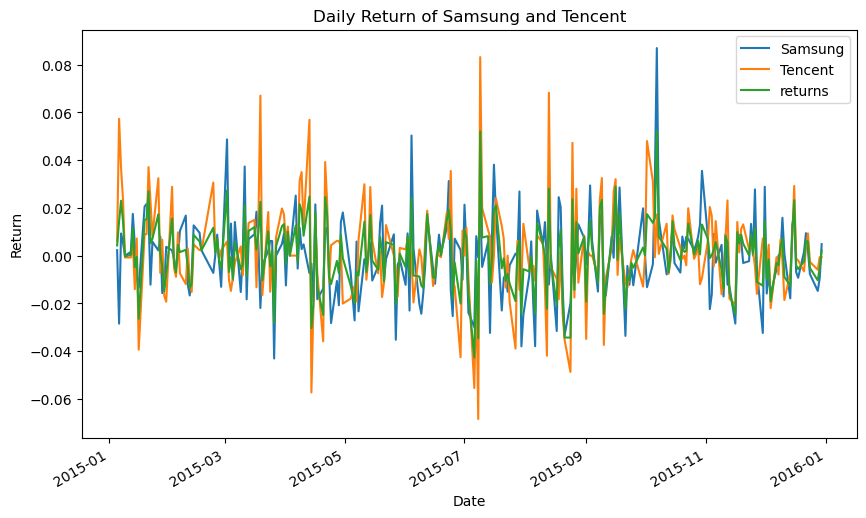

In [10]:
# Plot the Samsung and Tencent stock return
unstressed_portfolio_daily_returns.plot(figsize=(10, 6))
plt.title("Daily Return of Samsung and Tencent")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(False)
plt.show()

### Stressed economic condition

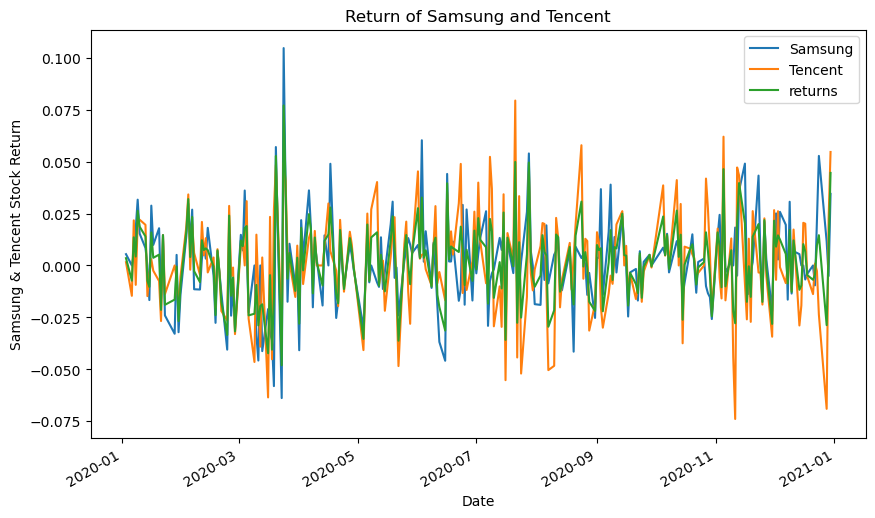

In [11]:
# Plot the Samsung and Tencent stock return
stressed_portfolio_daily_returns.plot(figsize=(10, 6))
plt.title("Return of Samsung and Tencent")
plt.xlabel("Date")
plt.ylabel("Samsung & Tencent Stock Return")
plt.grid(False)
plt.show()

### What is VaR?

The VaR(5%) of USD10,000 indicates that here is a 5% chance that on any given day, the portfolio will experience a loss of USD10,000 or more.

We could also say that there is a 95% chance that on any given day the portfolio will experience either a loss less than USD 10,000 or a gain.

If we further assume that the USD 10,000 loss represents 8% of the portfolio value, then on any given day there is a 5% chance that the portfolio will experience a loss of 8% or greater, but there is a 95%
chance that the loss will be less than 8% or a percentage gain greater than zero.

A VaR measure is typically estimated with three approaches. Let's first see the parametric approach, which requires specific assumptions regarding the asset returns distribution - for example, that they are normally distributed.

There are 2 parametric approached: the SMA and the EWMA.

## 2.A/ Parametric Approach 1# : Simple Moving Average 
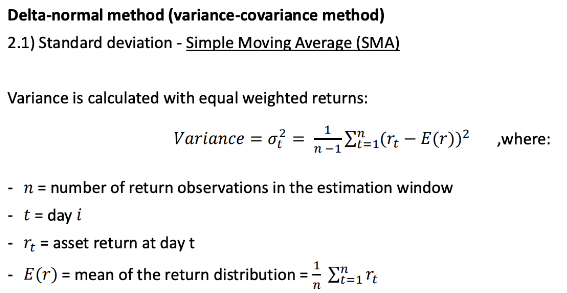

The SMA approach gives equal importance to all observations used in the look back period and does
not account for the fact that information tends to decay or become less relevant over time.

Daily VaR at 10% confidence level (Parametric SMA): 176.36€


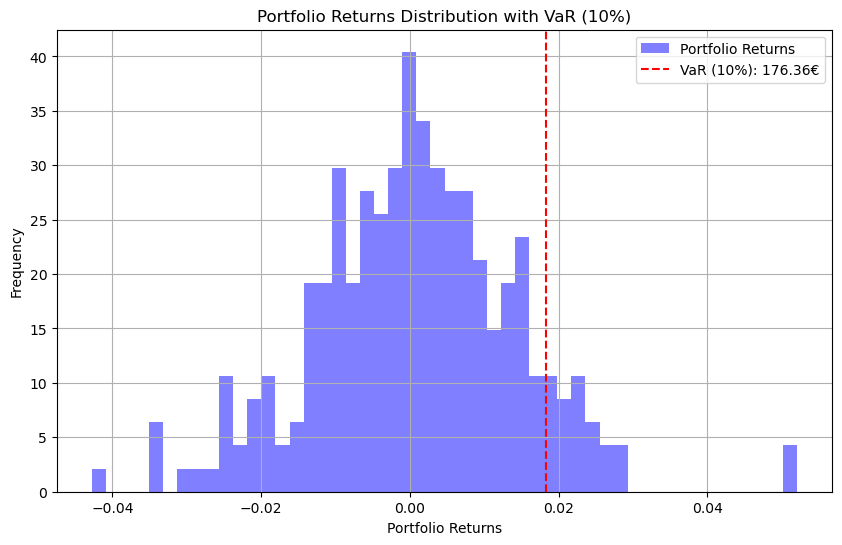

In [12]:
def plot_returns_distribution_with_var(portfolio_returns, daily_var_eur, initial_portfolio_value):
    #Plot the distribution of portfolio returns with VaR line.
    plt.figure(figsize=(10, 6))
    plt.hist(portfolio_returns, bins=50, density=True, alpha=0.5, color='blue', label='Portfolio Returns')
    mean_return = np.mean(portfolio_returns)
    plt.axvline(mean_return - daily_var_eur/initial_portfolio_value, color='red', linestyle='--', label=f'VaR (10%): {abs(daily_var_eur):.2f}€')
    plt.xlabel('Portfolio Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Returns Distribution with VaR (10%)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def var_SMA(portfolio_returns, portfolio_volatility, initial_portfolio_value, confidence_level=0.1):   
    #Calculate the daily Value at Risk (VaR) at a given confidence level using the parametric approach."""
    z_value = norm.ppf(1 - confidence_level)
    var_SMA = z_value * portfolio_volatility
    # Calculate the daily VaR (10%) using the parametric approach with SMA
    daily_var_eur = - var_SMA * initial_portfolio_value
    
    # Print the daily VaR at 10% confidence level
    print(f"Daily VaR at 10% confidence level (Parametric SMA): {abs(daily_var_eur):.2f}€")
    
    return var_SMA, daily_var_eur

initial_portfolio_value = 10000

# Compute VAR SMA
var_SMA, var_SMA_eur = var_SMA(unstressed_portfolio_daily_returns["returns"], unstressed_portfolio_vol, initial_portfolio_value)

# Plot the distribution of portfolio returns with VaR (10%)
plot_returns_distribution_with_var(unstressed_portfolio_daily_returns["returns"], var_SMA_eur, initial_portfolio_value)


### Comments:

The histogram illustrates the distribution of portfolio returns, and the red dotted line represents the VaR at a 10% confidence level.

The VaR (10%) indicates the potential loss threshold that is not expected to be exceeded with a probability of 10% over the specified holding period.

If the portfolio is equal-weighted, we have a 10% confidence level daily "Value at Risk" (VaR) of €176.36. 
This means that, under normal market conditions, there is 90% confidence (or a 90% probability) that the maximum loss your portfolio could sustain in one day will not exceed €176.36. Conversely, it also means that there is a 10% chance that the loss will exceed this amount.


# Parametric Approch #2 : Exponentially Weighted Moving Average (EWMA)

The EWMA method, on contrary to SMA method, gives more importance to recent information and hence places greater weight on more recent returns. This is achieved by specifying a parameter, Lambda, (0<λ<1) and placing exponentially declining weights on historical data.

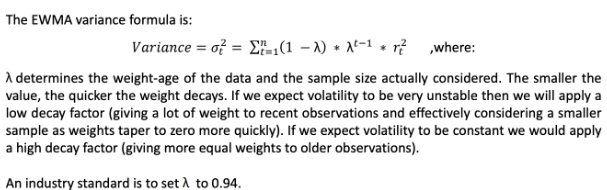

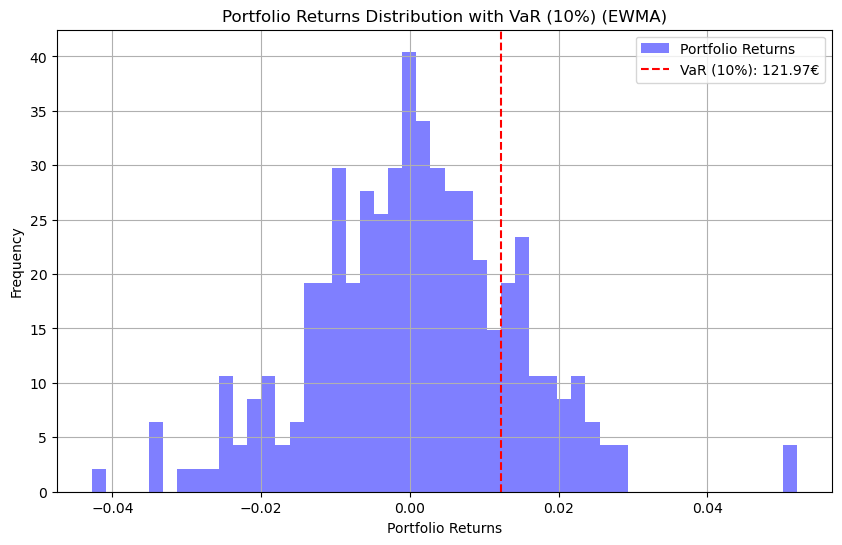

In [13]:
initial_portfolio_value = 10000  # Initial value of the portfolio
lambda_param = 0.94  # Lambda for EWMA

def calculate_ewma_std_dev(returns, lambda_param):
    weights = np.array([(1 - lambda_param) * (lambda_param ** i) for i in range(len(returns))])[::-1]
    ewma_variance = np.sum(weights * (returns ** 2))
    ewma_std_dev = np.sqrt(ewma_variance)
    return ewma_std_dev

# Calculate EWMA variance
ewma_std_dev = calculate_ewma_std_dev(unstressed_portfolio_daily_returns["returns"], lambda_param)

def var_EMWA(ewma_std_dev, initial_portfolio_value, confidence_level=0.1):
    # Calculate the daily VaR at 10%
    confidence_level = 0.1
    z_value = norm.ppf(1 - confidence_level)
    var_EMWA = z_value * ewma_std_dev
    var_EMWA_eur = - var_EMWA * initial_portfolio_value
    return var_EMWA, var_EMWA_eur

# Plot the distribution of portfolio returns with VaR (10%)
def plot_distribution_with_var(portfolio_returns, daily_var_ewma):
    plt.figure(figsize=(10, 6))
    plt.hist(portfolio_returns, bins=50, density=True, alpha=0.5, color='b', label='Portfolio Returns')
    # The VaR should be a threshold indicating potential loss, ensure it's plotted correctly:
    plt.axvline(-daily_var_ewma / initial_portfolio_value, color='r', linestyle='--',label=f'VaR (10%): {abs(daily_var_ewma):.2f}€')
    plt.xlabel('Portfolio Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Returns Distribution with VaR (10%) (EWMA)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the daily VaR (10%) using the parametric approach with SMA
var_EMWA, var_EMWA_eur = var_EMWA(ewma_std_dev, initial_portfolio_value)

# Plot the distribution of portfolio returns with VaR (10%)
plot_distribution_with_var(unstressed_portfolio_daily_returns["returns"], var_EMWA_eur)

### Comments

The histogram illustrates the distribution of portfolio returns using the EWMA approach, while the red dashed line represents the VaR at a 10% confidence level.
The VaR (10%) indicates the potential loss threshold that is not expected to be exceeded with a 10% probability over the specified holding period.
The lambda parameter for EWMA is set to 0.94.
Daily VaR at 10% confidence level using EWMA is €121.97.

# Non parametric approach using historical simulation

Value at Risk (VaR) is estimated directly from the data without deriving parameters or making assumptions about the entire distribution of the data. This methodology is based on the premise that the pattern of historical returns is indicative of future returns.

The easiest way to calculate the X% daily VaR using the historical method is to accumulate a number of past returns, rank the returns from highest to lowest, and identify the lowest X% of returns. The highest of these lowest X% of returns is the 1-day, X% VaR.

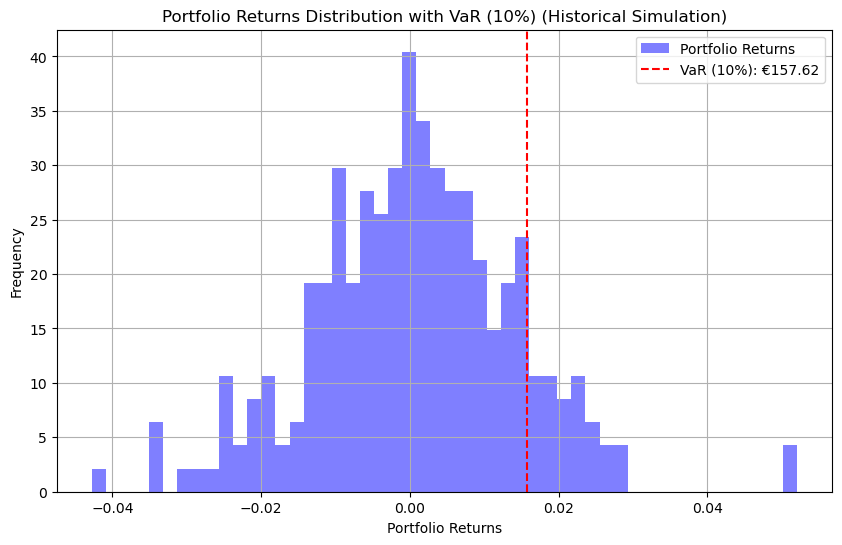

In [14]:
# Initial portfolio value
initial_portfolio_value = 10000  # in euros

# Calculate the historical simulation VaR at 10% confidence level
confidence_level = 0.1

def historical_var(portfolio_returns, initial_portfolio_value, confidence_level):
    histo_var = -np.quantile(portfolio_returns, confidence_level)
    # Convert VaR percentage to monetary value based on the initial portfolio value
    histo_var_euros = histo_var * initial_portfolio_value
    
    return histo_var, histo_var_euros
    
# Plot the distribution of portfolio returns
def plot_distribution(portfolio_returns, historical_var_euros, histo_var):
    plt.figure(figsize=(10, 6))
    plt.hist(portfolio_returns, bins=50, density=True, alpha=0.5, color='b', label='Portfolio Returns')
    plt.axvline(histo_var, color='r', linestyle='--', label=f'VaR (10%): €{abs(historical_var_euros):.2f}')
    plt.xlabel('Portfolio Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Returns Distribution with VaR (10%) (Historical Simulation)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
histo_var, histo_var_euros = historical_var(unstressed_portfolio_daily_returns["returns"], initial_portfolio_value, confidence_level)

plot_distribution(unstressed_portfolio_daily_returns["returns"], histo_var_euros, histo_var)


### Comments

The 10% historical simulation VaR is €157.62, which means that with 90% confidence, we expect that our portfolio will not lose more than this amount in a given day.

# Hybrid Approach

The hybrid approach combines techniques of both parametric and nonparametric methods to estimate volatility using historical data. The adjustment to the equal-weighted assumption used in historical simulation is to weight recent observations more and distant observations less (similar to EWMA).

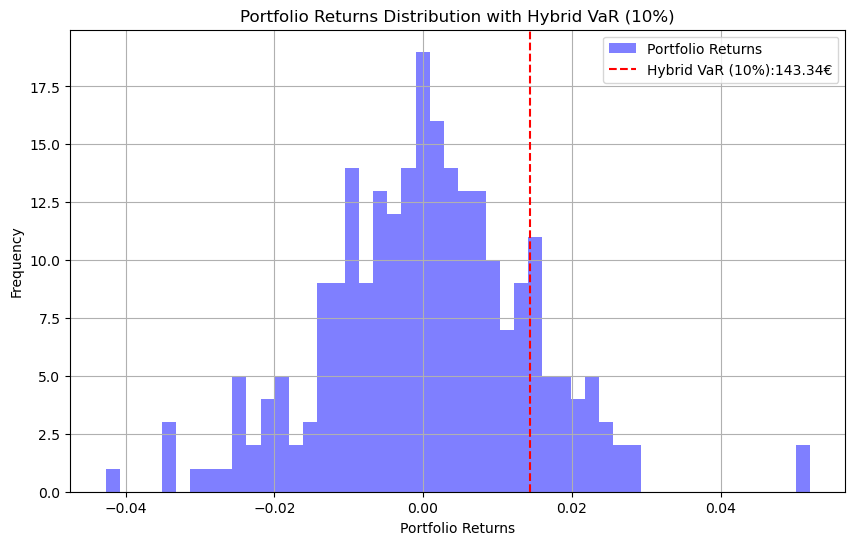

In [15]:
# Define the confidence level
confidence_level = 0.10
lambda_param = 0.94
initial_portfolio_value = 10000

def hybrid_var(portfolio_returns, lambda_param, confidence_level, initial_portfolio_value):

    n = len(portfolio_returns)

    # Assign weight for each historical realized return using the exponential smoothing process
    #   weights is an array of the weighted factors assigned to each historical return, 
    #   which decreases exponentially for older returns.
    weights = (lambda_param ** (np.arange(n, 0, -1) - 1)) * (1 - lambda_param) / (1 - lambda_param ** n)

    # Order the returns from highest to lowest
    ordered_returns = portfolio_returns.sort_values(ascending=False)

    # Apply the weights to the ordered returns
    weighted_ordered_returns = ordered_returns * weights

    # Determine the VaR for the portfolio
    cumulative_weights = np.cumsum(weights[np.argsort(ordered_returns)])
    var_index = np.argmax(cumulative_weights >= (1 - confidence_level))
    var_hybrid = ordered_returns.iloc[var_index]

    # Calculate the VaR in euros
    var_hybrid_euros = initial_portfolio_value * (1 + var_hybrid)
    
    return var_hybrid, var_hybrid_euros

var_hybrid, var_hybrid_euros = hybrid_var(unstressed_portfolio_daily_returns["returns"], lambda_param, confidence_level, initial_portfolio_value)

# Plot the distribution of portfolio returns with the VaR line
plt.figure(figsize=(10, 6))
plt.hist(unstressed_portfolio_daily_returns["returns"], bins=50, alpha=0.5, color='blue', label='Portfolio Returns')
plt.axvline(var_hybrid, color='red', linestyle='--', label=f'Hybrid VaR (10%):{abs(var_hybrid_euros - initial_portfolio_value):.2f}€')
plt.title('Portfolio Returns Distribution with Hybrid VaR (10%)')
plt.xlabel('Portfolio Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### Comments

The 10% hybrid VaR is €143.34, which means that with 90% confidence, we expect that our portfolio will not lose more than this amount in a given day.

### Monte Carlo  

The Monte Carlo method, which consists in generating a large number of different simulations of portfolio asset returns following a certain distribution law, and calculating the VaR for each of these different simulations. By averaging the VaR of a large number of each scenario, we get a greater precision thanks to the Central Limit Theorem. In fact this technique relies on adding randomness and thus achieve greater precision and confidence in VaR calculations. On the other hand, this technique is very costly in terms of computing power. 

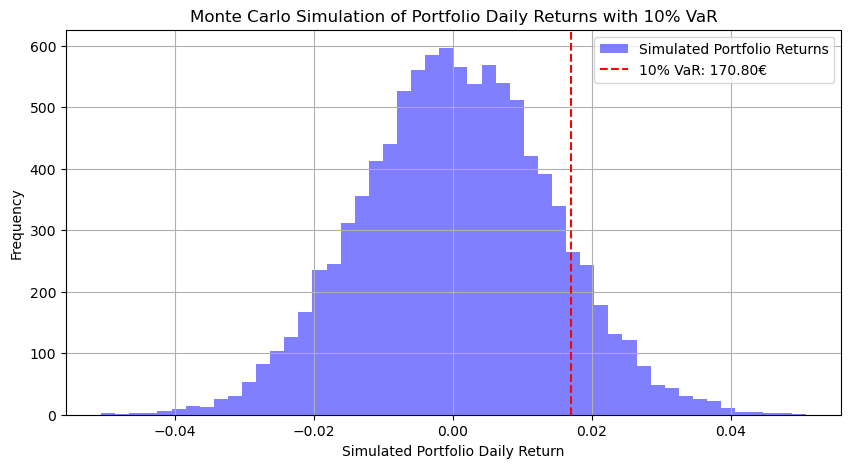

In [16]:
# Number of simulations
n_simulations = 10000
# Daily simulations
time_horizon = 1 
confidence_level = 0.1
initial_portfolio_value = 10000

def monter_carlo_var(portfolio_returns, portfolio_volatility, initial_portfolio_value, time_horizon, n_simulations, confidence_level):

    # Simulate daily returns using the mean and volatility of the portfolio returns
    simulated_daily_returns = np.random.normal(portfolio_returns.mean(), portfolio_volatility, (n_simulations, time_horizon))

    # Calculate the VaR at the 10th percentile
    var_monte_carlo = -np.quantile(simulated_daily_returns, confidence_level)
    var_monte_carlo_eur = var_monte_carlo * initial_portfolio_value
    return var_monte_carlo, var_monte_carlo_eur, simulated_daily_returns

var_monte_carlo, var_monte_carlo_eur, simulated_daily_returns = monter_carlo_var(unstressed_portfolio_daily_returns["returns"], unstressed_portfolio_vol, initial_portfolio_value, time_horizon, n_simulations, confidence_level)

# Plot the histogram of the simulated daily returns
plt.figure(figsize=(10, 5))
plt.hist(simulated_daily_returns, bins=50, alpha=0.5, color='blue', label='Simulated Portfolio Returns')
plt.axvline(x=var_monte_carlo, color='red', linestyle='--', label=f'10% VaR: {var_monte_carlo_eur:.2f}€')
plt.title('Monte Carlo Simulation of Portfolio Daily Returns with 10% VaR')
plt.xlabel('Simulated Portfolio Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Comparison of the different models 

The SMA (Simple Moving Average) approach gives a VaR of €176.36, the EWMA (Exponentially Weighted Moving Average) gives a VaR of €121.97, the historical simulation method gives a VaR of €157.62, the hybrid approach yields a VaR of €143.34, and the Monte Carlo simulation approach yields a VaR of €167.69.

The SMA method gives equal weight to all observations in the look-back period, so this method might not be as responsive to recent market changes. 

In contrast, EWMA gives more weight to more recent returns, which can result in a lower VaR if recent market volatiliry is less than the long-term average. 

The historical simulation method does not assume a normal distribution and instead uses actual historical returns to calculate VaR, which can lead to different results if the historical data has outliers or is not symmetrically distributed.

The hybrid method typically combines elements of both historical simulation and a parametric approach, which might balance out the extremes of each individual method.

The Monte Carlo simulation approach relies on the statistical properties (mean and variance) of the simulated returns and might produce a VaR that reflects the modeled assumptions more than the actual historical data.

Across all methods, a 10% VaR means there is a 90% confidence that losses will not exceed the calculated VaR on any given day. However, there is a 10% chance that losses could exceed this amount, indicating the tail risk.

The choice of λ (lambda) in EWMA affects sensitivity to recent market moves. A λ close to 1 (like 0.94) puts less weight on the most recent returns, which might underestimate risk if the market becomes more volatile.

Lower VaR figures might indicate a method that is not capturing risk adequately, especially in turbulent markets, while a higher VaR suggests a more conservative approach to risk estimation.
Risk managers might prefer a method that aligns with their risk appetite and reflects the market conditions they expect to face.

To sum up: 

#### 1. SMA (Simple Moving Average) - €176.36 VaR:

- Tends to give a higher VaR, indicating a more conservative approach to risk.
- Assumes equal weight to historical data, which may not be responsive to recent market trends or volatility spikes.
- Might be preferred if the goal is to maintain a conservative stance and the market conditions have been stable or the historical period used is representative of current conditions.

#### 2. EWMA (Exponentially Weighted Moving Average) - €121.97 VaR:

- Gives more weight to recent data, potentially making it more responsive to recent market volatility.
- A lower VaR might suggest it's less conservative, which could be preferable in a stable market or if recent data is more reflective of current conditions.
- The choice of the lambda parameter is crucial; λ=0.94 implies a slow decay, meaning it still considers relatively old observations quite strongly.

#### 3. Historical Simulation - €157.62 VaR:

- Does not assume a normal distribution and uses actual historical data, which can capture events like market crashes or booms.
- May be preferable if you believe that the historical data contains relevant scenarios that could occur again.

#### 4. Hybrid Approach - €143.34 VaR:

- Combines elements of both historical simulation and parametric models.
- Might offer a balance between responsiveness to market conditions and a conservative stance.
- Could be considered more robust as it doesn't rely solely on one type of data or method.

#### 5. Monte Carlo Simulation - €167.69 VaR:

- Based on statistical properties of the portfolio and allows for the modeling of various scenarios, including atypical events.
- Can be tuned to model complex instruments or portfolios that do not follow standard market patterns.
- Often preferred if the portfolio contains complex derivatives or non-linear instruments.
- One drawback of this methids is that it's highly cost computational

# 3. VaR Conversion

For the parametric approach using SMA, 
* (i) calculate the weekly, monthly and annual VaR (10%) and 
* (ii) convert the VaR (10%) to VaR (1%).

In [17]:
# Assuming `daily_var_eur` is calculated using the previously defined functions in the SMA part 
daily_var_eur = var_SMA_eur


# Calculate weekly, monthly, and annual VaR (10%)
def scale_var(daily_var, scale):
    return daily_var * np.sqrt(scale)

# Convert VaR from one confidence level to another
def convert_var(confidence_level_from, confidence_level_to, var):
    var_level_from = norm.ppf(1 - confidence_level_from)
    var_level_to = norm.ppf(1 - confidence_level_to)
    return var * (var_level_to / var_level_from)

# Scales for weekly, monthly, and annual calculations
weekly_scale = 5  # 5 trading days in a week
monthly_scale = 22  # Approx. 22 trading days in a month
annual_scale = 252  # Approx. 252 trading days in a year

# Calculate scaled VaRs
weekly_var_eur = scale_var(daily_var_eur, weekly_scale)
monthly_var_eur = scale_var(daily_var_eur, monthly_scale)
annual_var_eur = scale_var(daily_var_eur, annual_scale)

# Convert VaR (10%) to VaR (1%)
daily_var_1_percent = convert_var(0.1, 0.01, daily_var_eur)
weekly_var_1_percent = convert_var(0.1, 0.01, weekly_var_eur)
monthly_var_1_percent = convert_var(0.1, 0.01, monthly_var_eur)
annual_var_1_percent = convert_var(0.1, 0.01, annual_var_eur)

# Print the results
print(f"Weekly VaR at 10% confidence level: {weekly_var_eur:.2f}€")
print(f"Monthly VaR at 10% confidence level: {monthly_var_eur:.2f}€")
print(f"Annual VaR at 10% confidence level: {annual_var_eur:.2f}€")
print(f"Daily VaR at 1% confidence level: {daily_var_1_percent:.2f}€")
print(f"Weekly VaR at 1% confidence level: {weekly_var_1_percent:.2f}€")
print(f"Monthly VaR at 1% confidence level: {monthly_var_1_percent:.2f}€")
print(f"Annual VaR at 1% confidence level: {annual_var_1_percent:.2f}€")


Weekly VaR at 10% confidence level: -394.36€
Monthly VaR at 10% confidence level: -827.21€
Annual VaR at 10% confidence level: -2799.67€
Daily VaR at 1% confidence level: -320.14€
Weekly VaR at 1% confidence level: -715.86€
Monthly VaR at 1% confidence level: -1501.61€
Annual VaR at 1% confidence level: -5082.13€


Comment on the results: 
- The weekly VaR at 10% is -394.36€, this means that here is a 10% chance that our portfolio will lose more than 394.36€ of its value over the course of a week. 

- The monthly VaR at 10% is -827.21€, this indicates that there is a 10% chance that our portfolio will lose more than 827.21€ of its value over a month. 

- The annual VaR at 10% is -2799.67€, so there is a 10% chance that our portfolio will lose more than 2799.67€ of its value over a year. 

And fore the VaR at 1%, there is a 1% chance that our portfolio will lose more than 715.86€ of its value over the course of a week, more than 1501.61€ over a month and 5082.13€ over a year. 

Note that the VaR values at 1% confidence level represent extreme risk scenarios.

# 4. Stressed VaR

For the non-parametric approach, 
* (i) calculate a Stressed VaR (10%) in € of your investment portfolio based on a time series of one year during stressed economic conditions (select any crisis period of your choice), 
* (ii) compare the non-parametric Stressed VaR to the non-parametric VaR estimated in 2. c), 
* (iii) interpret your results. 

2015 VaR (10%) in €: 157.62
2020 Stressed VaR (10%) in €: 219.61


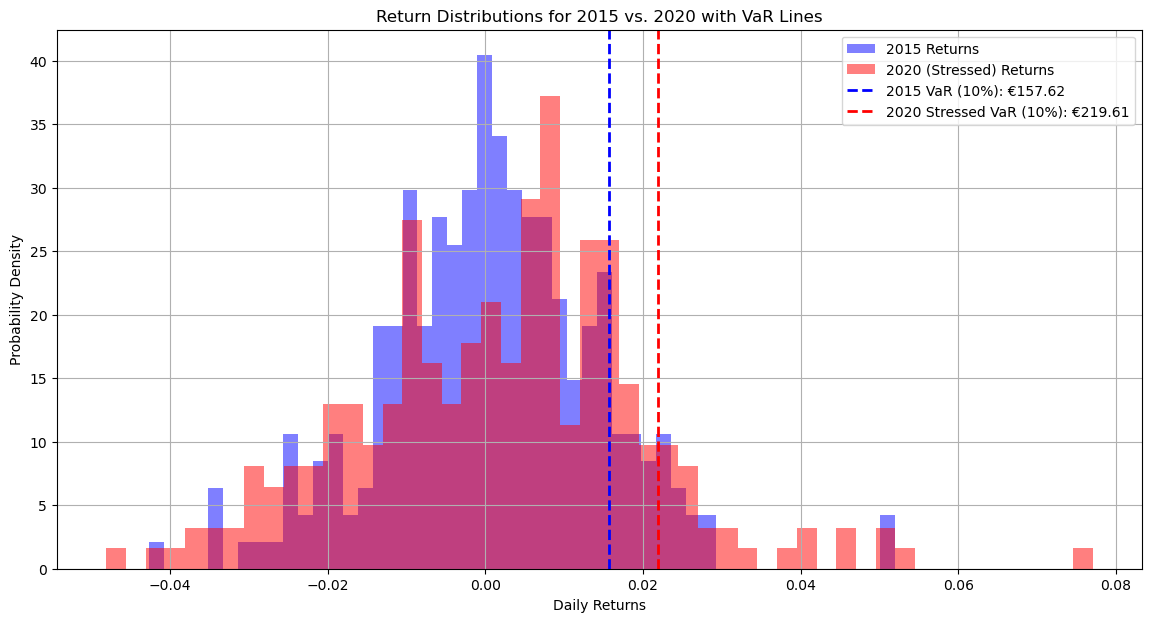

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

initial_portfolio_value = 10000
confidence_level = 0.1

def stressed_unstressed_var(unstressed_portfolio_daily_returns, stressed_portfolio_daily_returns, initial_portfolio_value, confidence_level):

    # Calculate the 10th percentile (VaR at 10% confidence level) for both periods
    unstressed_var = -np.quantile(unstressed_portfolio_daily_returns["returns"], confidence_level)
    stressed_var = -np.quantile(stressed_portfolio_daily_returns["returns"], confidence_level)

    # Calculate VaR in € for an initial investment of €10,000

    unstressed_var_eur = unstressed_var * initial_portfolio_value
    stressed_var_eur = stressed_var * initial_portfolio_value

    # Output the calculated VaRs in €
    print(f"2015 VaR (10%) in €: {unstressed_var_eur:.2f}")
    print(f"2020 Stressed VaR (10%) in €: {stressed_var_eur:.2f}")
    
    return unstressed_var, stressed_var, unstressed_var_eur, stressed_var_eur

unstressed_var, stressed_var, unstressed_var_eur, stressed_var_eur = stressed_unstressed_var(unstressed_portfolio_daily_returns, stressed_portfolio_daily_returns, initial_portfolio_value, confidence_level)

# Plot the distribution of returns for 2015 and 2020 with VaR lines
plt.figure(figsize=(14, 7))
plt.hist(unstressed_portfolio_daily_returns["returns"], bins=50, alpha=0.5, label='2015 Returns', color='blue', density=True)
plt.hist(stressed_portfolio_daily_returns["returns"], bins=50, alpha=0.5, label='2020 (Stressed) Returns', color='red', density=True)
plt.axvline(unstressed_var, color='blue', linestyle='dashed', linewidth=2, label=f'2015 VaR (10%): €{unstressed_var_eur:.2f}')
plt.axvline(stressed_var, color='red', linestyle='dashed', linewidth=2, label=f'2020 Stressed VaR (10%): €{stressed_var_eur:.2f}')
plt.legend(loc='upper right')
plt.title("Return Distributions for 2015 vs. 2020 with VaR Lines")
plt.xlabel("Daily Returns")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()


Interpretation of the result and comparison with the non-parametric VaR: the Stressed VaR is higher than the VaR under normal economic conditions.

# 5. Compute CVaR for normal economic conditions

### What is CVaR

The conditional value-at-risk statistic, or CVaR, asks what the expected loss will be if the loss exceeds the VaR. CVaR is the expected value of the loss on the tail of the loss distribution. Note that CVaR is sometimes expressed using the confidence level, 95%, and sometimes using the significance level, which is 100% minus the confidence level, or in this case 5%.

CVaR is a richer measure of risk than VaR, but can be more difficult to calculate when the distribution of losses (or returns) is unknown or more complicated than a normal distribution. Nevertheless, both measures are used in risk management to identify "danger signs" when portfolio losses approach the VaR or CVaR threshold.

CVaR is the average expected loss given that the portfolio return already lies below the pre specified worst case quantile return

It is important to know that, CVaR does not provide any estimate of the magnitude of losses, only the probability that they might occur However, CVaR method provides an estimate of how large of a loss is expected if an unfavourable event occurs

For the parametric and non-parametric approaches:

* (i) calculate Expected Shortfall for the 5 th percent quantile [= CVaR (5%)], 
* (ii) explain the methodology, 
* (iii) plot the result, 
* (iv) comment the result, 
* (v) compare the results of the two approaches.

### CVaR(5%) non-parametric approach (historical approach)

To derive the CVaR from the non-parametric approach, first we have to compute the VaR at the confidence level of 95% (because we want to compute the CVaR(5%)) using the `quantile` function from the python numpy library. Then, by calculating the average of all returns less than or equal to the VaR(5%), we can calculate the CVaR(5%). This means that the CVaR will always be less than the VaR for the same quantile.

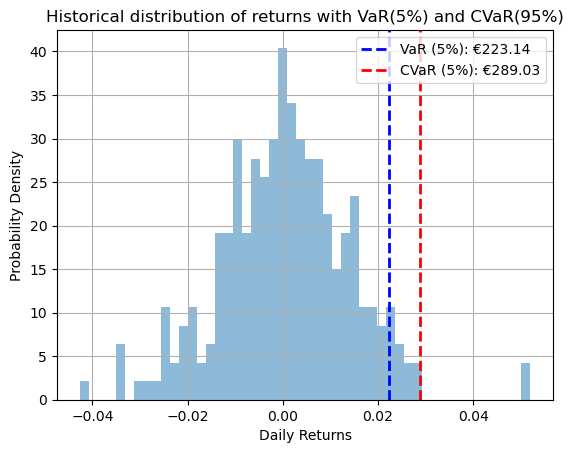

VaR(5%): 0.022314341413949144
CVaR(95%) 0.02890341393652327


In [19]:
initial_portfolio_value = 10000
confidence_level = 0.95

def cvar_non_param(portfolio_returns, initial_portfolio_value, confidence_level):
    var_non_param_5 = -np.quantile(portfolio_returns, 1-confidence_level)
    cvar_non_param_5 = -portfolio_returns[portfolio_returns <= -var_non_param_5].mean()
    
    var_non_param_5_eur = var_non_param_5 * initial_portfolio_value
    cvar_non_param_5_eur = cvar_non_param_5 * initial_portfolio_value
    
    plt.hist(portfolio_returns,bins=50, alpha=0.5, density=True, stacked=True)
    
    plt.axvline(var_non_param_5, color='blue', linestyle='dashed', linewidth=2, label=f'VaR (5%): €{var_non_param_5_eur:.2f}')
    plt.axvline(cvar_non_param_5, color='red', linestyle='dashed', linewidth=2, label=f'CVaR (5%): €{cvar_non_param_5_eur:.2f}')
    plt.legend(loc='upper right')
    plt.title("Historical distribution of returns with VaR(5%) and CVaR(95%)")
    plt.xlabel("Daily Returns")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.show()
    
    print("VaR(5%):", var_non_param_5)
    print("CVaR(95%)", cvar_non_param_5)

    return var_non_param_5, cvar_non_param_5, var_non_param_5_eur, cvar_non_param_5_eur
    
var_non_param_5, cvar_non_param_5, var_non_param_5_eur, cvar_non_param_5_eur = cvar_non_param(unstressed_portfolio_daily_returns["returns"], initial_portfolio_value, confidence_level)

### CVaR parametric approach

To calculate the CVaR, first we specify the confidence level (in the case 0.95). Next, we need to specify the return distribution sample. In this parametric approach as we know the distribution we calculate the VaR at this confidence level, using the `.ppf()` method of the `norm` object in order to obtain the z-value at confidence level of 95%. We could also have used the quantile method on losses, if we wished, but the percentage point function is very useful when the distribution is known. VaR is used as a lower bound to find the expected value of the tail loss. As we suppose that our return are normally distributed, the `.expect()` method attached to the `norm` object will calculate the CVaR. If the return are not normally distributed, the expected value is calculated using the integral show below, in the CVaR definition.

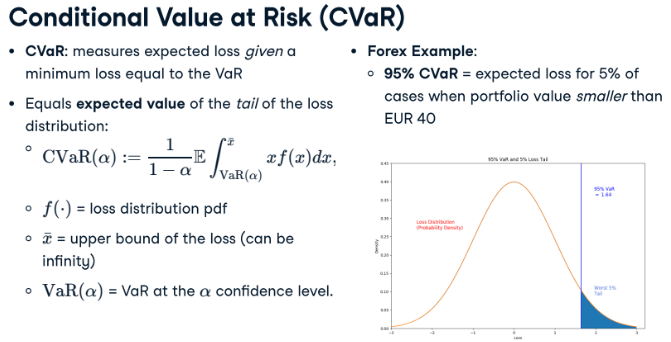

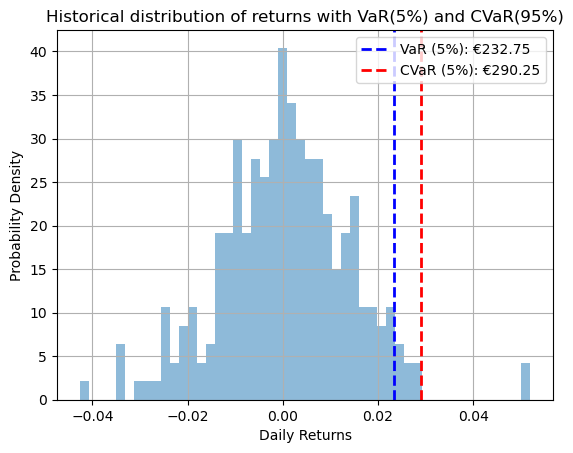

VaR(5%): 0.023274608154773647
CVaR(95%) 0.02902504603994846


In [21]:
initial_portfolio_value = 10000
confidence_level = 0.95

def cvar_param(portfolio_returns, initial_portfolio_value, confidence_level):
    
    portfolio_returns_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()
    
    var_param_5 = norm.ppf(confidence_level, loc=portfolio_returns_mean, scale=portfolio_std)
    tail_loss = norm.expect(lambda x: x, loc=portfolio_returns_mean, scale=portfolio_std, lb=var_param_5)
    cvar_param_5 = (1 / (1 - confidence_level)) * tail_loss
    
    var_param_5_eur = var_param_5 * initial_portfolio_value
    cvar_param_5_eur = cvar_param_5 * initial_portfolio_value
    
    plt.hist(portfolio_returns,bins=50, alpha=0.5, density=True, stacked=True)
    
    plt.axvline(var_param_5, color='blue', linestyle='dashed', linewidth=2, label=f'VaR (5%): €{var_param_5_eur:.2f}')
    plt.axvline(cvar_param_5, color='red', linestyle='dashed', linewidth=2, label=f'CVaR (5%): €{cvar_param_5_eur:.2f}')
    plt.legend(loc='upper right')
    plt.title("Historical distribution of returns with VaR(5%) and CVaR(95%)")
    plt.xlabel("Daily Returns")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.show()
    
    print("VaR(5%):", var_param_5)
    print("CVaR(95%)", cvar_param_5)
    
    return var_param_5, cvar_param_5, var_param_5_eur, cvar_param_5_eur
    
var_param_5, cvar_param_5, var_param_5_eur, cvar_param_5_eur = cvar_param(unstressed_portfolio_daily_returns["returns"], initial_portfolio_value, confidence_level)

### Comment

We note that the CVaRs calculated by the two methods (parametric vs. non-parametric) are very close. 

### General comments

There is no reason to limit to VaR(95) or CVaR(95) - analysts often use the 99th quantile, or even the 99.9 quantile, to obtain more severe forecasts of potential losses. If we always use the 95th percentile, we will tend to underestimate your risk 5% of the time! For greater certainty, we can increase the quantile. Of course, the higher the quantile, the higher the potential losses, sometimes quite dramatically. This can lead to an overestimation of the risk, which can cause a loose money through over-cautiousness. That's why it's important to test different quantile parameters to find the right balance between risk and reward.

VaR and CVaR are similar, CVaR is generally the preferred risk measure for risk management. One reason for this is that it is influenced by the tail of the loss distribution, whereas VaR is a static value.

The shape and mass of the tail of the distribution contribute to the expected value, so CVaR makes good use of tail information (it also requires VaR, which remains an important statistic).
The CVaR is an expected value for all losses exceeding the VaR, which are precisely the tail.


In short, CVaR, is a measure of the expected value of losses in the worst-case scenario (1 minus x %), hence the alternative term "expected shortfall". For example, if CVaR(95) = -2.5% means that in the worst 5% of cases, losses will average -2.5%. Essentially, this means taking the average of losses exceeding the VaR(95) level. Like VaR, CVaR 95, 99 and 99.9 are common.

We have learned the following from this exercise:
* CVaR cannot be lower than a VaR estimate
* VaR answers the question ::“How often could my portfolio lose at least X?”
* CVaR answers the question ::“If my portfolio loses more than X, how much could it lose?”